# Código de Validação cruzada entre as bases

Pega os modelos gerados pelos treinamentos individuais e testa com as outras bases

O objetivo consiste em extrair informações como:

- Qual a melhor base para treinar a rede, ou seja, identificar a base de treino com maior capacidade de generalização no treinamento
- Gerar um modelo treinado que tenha a maior capacidade de generalização
- Identificar as principais bases na literatura relacionadas a identificação de DeepFake de áudio

In [127]:
# importa as bibliotecas

import tensorflow as tf
import numpy as np
import pandas as pd
from random import shuffle
import os
from PIL import Image
from PIL import ImageFont
import matplotlib.pyplot as plt

import time
from keras.preprocessing.image import ImageDataGenerator  # , load_img
from keras.utils import to_categorical, plot_model
from keras.metrics import CategoricalAccuracy
from keras.models import load_model

#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import OrdinalEncoder

# Diretórios

In [128]:
os.getcwd()
Path = '/mnt/f/Google Drive/EnsinoAprendizagem/UFC/Mestrado/Dissertação/Datasets/'
FoRPath = "FoR/for-2sec-mel/"
ASVPath = "ASVspoof/PA/PA/"
WavePath = "WaveFake/newData/"

# Funções aplicadas

In [129]:
def createList(paths,classe):
    auxLista = []
    auxDir = []
    for i in paths:
        lista = os.listdir(i)
        try:
            lista.remove("desktop.ini")
        except:
            print("não existe desktop.ini")
        
        for j in lista:
            auxLista.append(classe)
            auxDir.append(i + j)
            
    return pd.DataFrame({'filename': auxDir, 'category': auxLista})

In [136]:
def datagenCreate(data, Path, IMAGE_SIZE, batch_size):
    test_datagen = ImageDataGenerator(
        rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        data,
        Path,
        x_col='filename',
        y_col='category',
        seed=30,
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )
    return test_generator

In [137]:
def prediction(data, total_test, batch_size, model):
    predict = model.predict(
        data,
        steps=np.ceil(total_test/batch_size),
        verbose=1)
    
    return predict

In [149]:
def plotConfusionMatrix(predicted,original):
    conf = confusion_matrix(y_pred=predicted,y_true=original)
    disp = ConfusionMatrixDisplay(conf)
    disp.plot()
    plt.show()

In [150]:
def results(dataModel, testModel, predicted, original):
    
    pred = []
    orig = []
    for cat in predicted:
        if cat == 'Fake':
            pred.append(0)
        else:
            pred.append(1)
            
    for cat in original:
        if cat == 'Fake':
            orig.append(0)
        else:
            orig.append(1)
    
    print("\nTraining Dataset: " + dataModel + "  Test Basis: " + testModel)
    print("Accuracy: " + str(accuracy_score(orig, pred)))
    print("F1-score: " + str(f1_score(orig, pred)))
    print("Precision: " + str(precision_score(orig, pred)))
    print("Recall: " + str(recall_score(orig, pred)))

# Preparação das Bases

Gera os dataframes de cada base com dados falsos e reais balanceados

In [130]:
os.chdir(Path + FoRPath)

real = createList(["testing/real/","training/real/","validation/real/"], 1)
fake = createList(["testing/fake/","training/fake/","validation/fake/"], 0)

FoRData = [real, fake]
FoRData = pd.concat(FoRData).replace({1: 'Real', 0: 'Fake'})

In [131]:
os.chdir(Path + WavePath)

real = createList(["realImgMEL/"],1)
fake = createList(["fakeImgMEL/"],0)
fake = fake.sample(frac=1).reset_index(drop=True)[:len(real)]


WaveData = [real, fake]
WaveData = pd.concat(WaveData).replace({1: 'Real', 0: 'Fake'})

In [132]:
os.chdir(Path + ASVPath)

real = createList(["realImgMEL/"],1)
fake = createList(["fakeImgMEL/"],0)
fake = fake.sample(frac=1).reset_index(drop=True)[:len(real)]

ASVData = [real, fake]
ASVData = pd.concat(ASVData).replace({1: 'Real', 0: 'Fake'})

não existe desktop.ini
não existe desktop.ini


In [133]:
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size = 32

In [134]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="adam"
)

# Fake or Real (FoR)

In [135]:
os.chdir(Path + FoRPath)
modelFoR = load_model("model-Mel.h5")
modelFoR.load_weights("FoR-weights-best-Mel.hdf5")
modelFoR.compile(
    loss='categorical_crossentropy',
    optimizer= opt,
    metrics=['categorical_accuracy']
)

In [138]:
testWave = WaveData
WaveDatagen = datagenCreate(testWave,
                        (Path + WavePath),
                        IMAGE_SIZE,
                        batch_size)
predict = prediction(WaveDatagen,
                     len(testWave["category"]),
                     batch_size,
                     modelFoR)

testWave['Pred_category'] = np.argmax(predict, axis=1)
testWave['Pred_category'] = testWave['Pred_category'].replace({1: 'Real', 0: 'Fake'})

Found 86818 validated image filenames belonging to 2 classes.
2714/2714 [==============================] - 1846s 678ms/step


In [139]:
testWave.to_csv('FoRtestWave.csv', index=False)

In [140]:
testASV = ASVData
ASVDatagen = datagenCreate(testASV,
                        (Path + ASVPath),
                        IMAGE_SIZE,
                        batch_size)
predict = prediction(ASVDatagen,
                     len(testASV["category"]),
                     batch_size,
                     modelFoR)

testASV['Pred_category'] = np.argmax(predict, axis=1)
testASV['Pred_category'] = testASV['Pred_category'].replace({1: 'Real', 0: 'Fake'})

Found 46948 validated image filenames belonging to 2 classes.
1468/1468 [==============================] - 775s 528ms/step


In [141]:
testASV.to_csv('FoRtestASV.csv', index=False)

<Figure size 640x480 with 0 Axes>

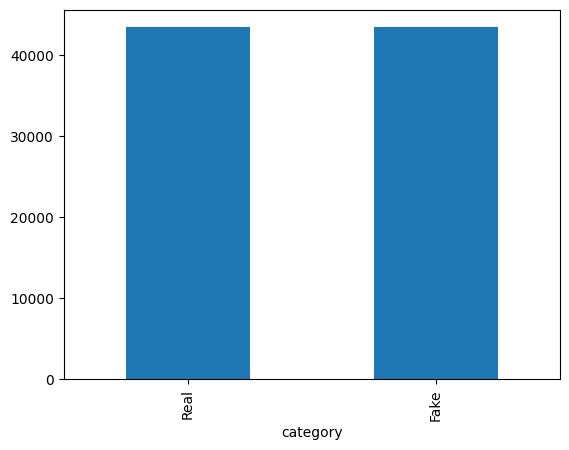

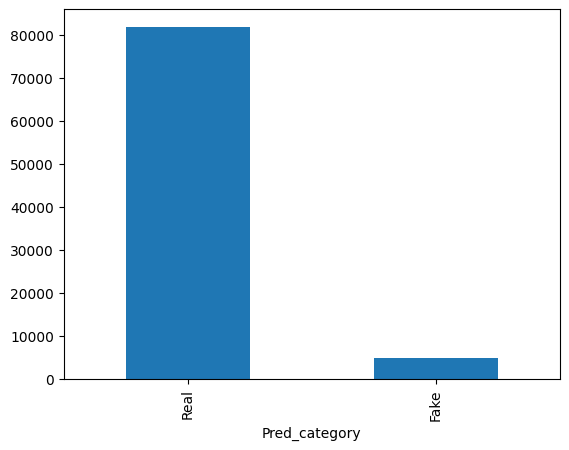

In [142]:
plt.figure()
plt.subplots(1, 1)
testWave['category'].value_counts().plot.bar()
plt.subplots(1, 1)
testWave['Pred_category'].value_counts().plot.bar()
plt.show()

<Figure size 640x480 with 0 Axes>

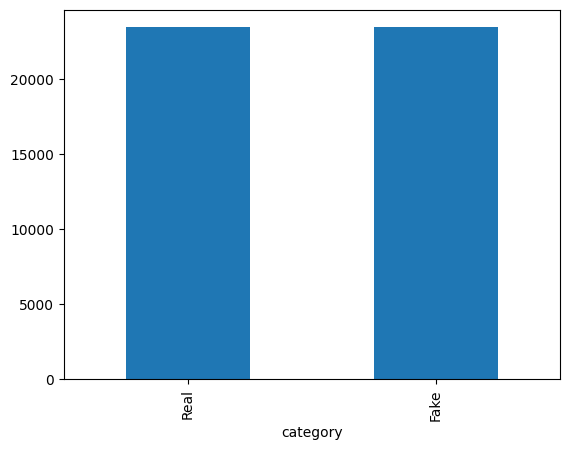

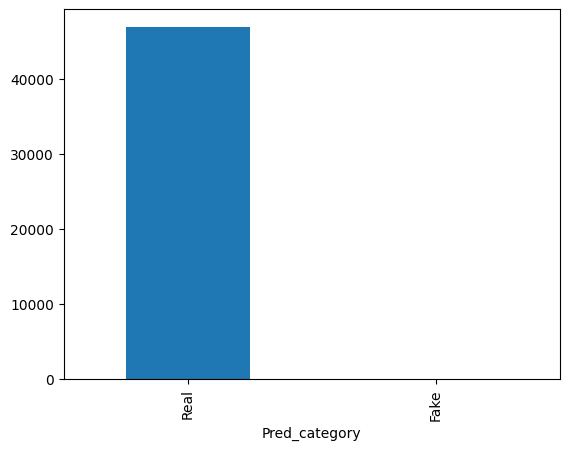

In [143]:
plt.figure()
plt.subplots(1, 1)
testASV['category'].value_counts().plot.bar()
plt.subplots(1, 1)
testASV['Pred_category'].value_counts().plot.bar()
plt.show()

In [144]:
testWave['category'].value_counts()

category
Real    43409
Fake    43409
Name: count, dtype: int64

In [145]:
testWave['Pred_category'].value_counts()

Pred_category
Real    81912
Fake     4906
Name: count, dtype: int64

In [146]:
testASV['category'].value_counts()

category
Real    23474
Fake    23474
Name: count, dtype: int64

In [147]:
testASV['Pred_category'].value_counts()

Pred_category
Real    46906
Fake       42
Name: count, dtype: int64

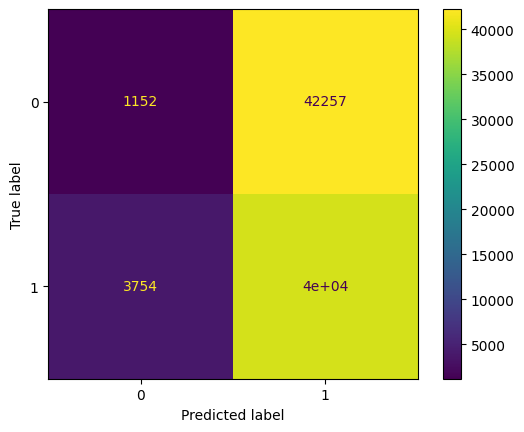


Training Dataset: FoR  Test Basis: Wavefake
Accuracy: 0.470029256605773
F1-score: 0.6328548287996426
Precision: 0.4841171012794218
Recall: 0.9135202377387178


In [151]:
plotConfusionMatrix(testWave['Pred_category'], testWave['category'])
results("FoR", "Wavefake",testWave["Pred_category"], testWave["category"])

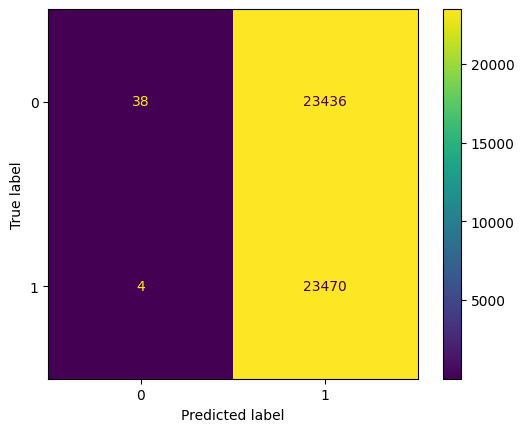


Training Dataset: FoR  Test Basis: ASVspoof
Accuracy: 0.5007242055039618
F1-score: 0.666950838306337
Precision: 0.5003624269816228
Recall: 0.9998295987049501


In [152]:
plotConfusionMatrix(testASV['Pred_category'], testASV['category'])
results("FoR", "ASVspoof",testASV["Pred_category"], testASV["category"])

# WaveFake

In [153]:
os.chdir(Path + WavePath)
modelWave = load_model("model-Mel.h5")
modelWave.load_weights("weights-best.hdf5")
modelWave.compile(
    loss='categorical_crossentropy',
    optimizer= opt,
    metrics=['categorical_accuracy']
)

In [154]:
testFoR = FoRData
FoRDatagen = datagenCreate(testFoR,
                        (Path + FoRPath),
                        IMAGE_SIZE,
                        batch_size)
predict = prediction(FoRDatagen,
                     len(testFoR["category"]),
                     batch_size,
                     modelWave)

testFoR['Pred_category'] = np.argmax(predict, axis=1)
testFoR['Pred_category'] = testFoR['Pred_category'].replace({1: 'Real', 0: 'Fake'})

Found 17870 validated image filenames belonging to 2 classes.
559/559 [==============================] - 414s 731ms/step


In [155]:
testFoR.to_csv('WavetestFoR.csv', index=False)

In [156]:
testASV = ASVData
ASVDatagen = datagenCreate(testASV,
                        (Path + ASVPath),
                        IMAGE_SIZE,
                        batch_size)
predict = prediction(ASVDatagen,
                     len(testASV["category"]),
                     batch_size,
                     modelWave)

testASV['Pred_category'] = np.argmax(predict, axis=1)
testASV['Pred_category'] = testASV['Pred_category'].replace({1: 'Real', 0: 'Fake'})

Found 46948 validated image filenames belonging to 2 classes.
1468/1468 [==============================] - 759s 517ms/step


In [157]:
testASV.to_csv('WavetestASV.csv', index= False)

<Figure size 640x480 with 0 Axes>

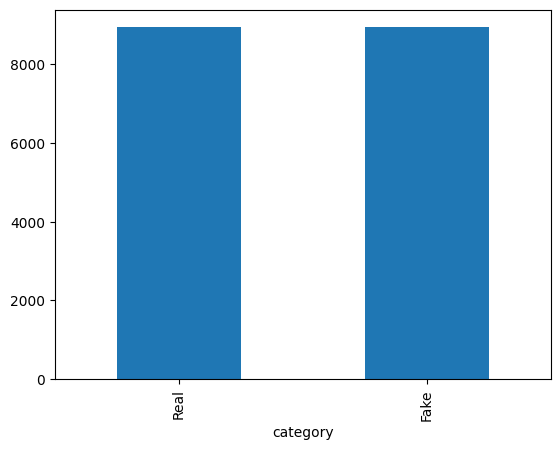

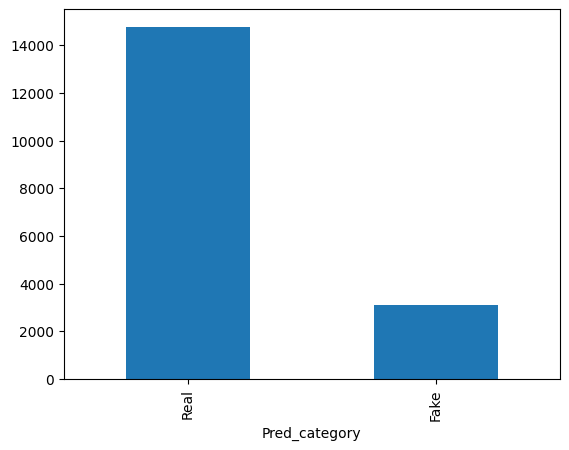

In [158]:
plt.figure()
plt.subplots(1, 1)
testFoR['category'].value_counts().plot.bar()
plt.subplots(1, 1)
testFoR['Pred_category'].value_counts().plot.bar()
plt.show()

<Figure size 640x480 with 0 Axes>

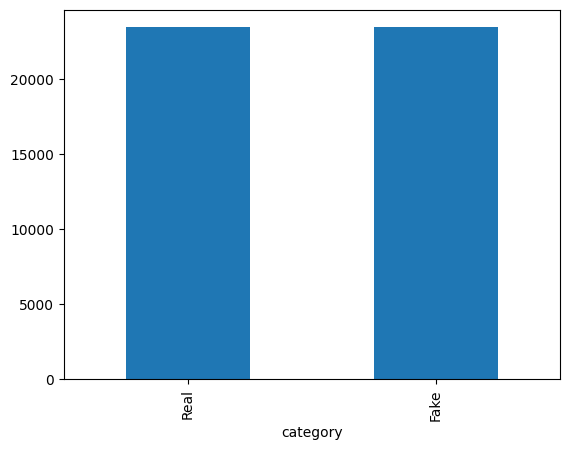

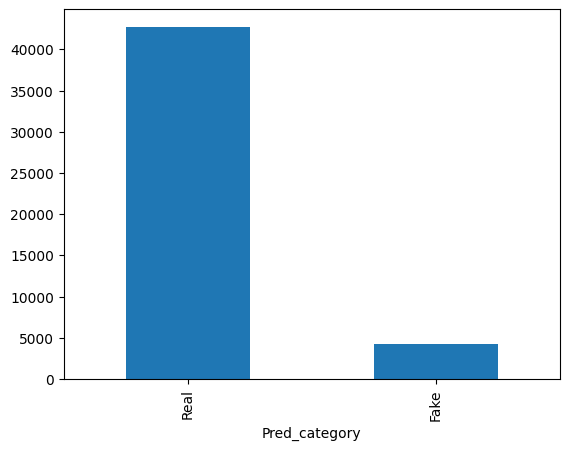

In [159]:
plt.figure()
plt.subplots(1, 1)
testASV['category'].value_counts().plot.bar()
plt.subplots(1, 1)
testASV['Pred_category'].value_counts().plot.bar()
plt.show()

In [160]:
testFoR['category'].value_counts()

category
Real    8935
Fake    8935
Name: count, dtype: int64

In [161]:
testFoR['Pred_category'].value_counts()

Pred_category
Real    14758
Fake     3112
Name: count, dtype: int64

In [162]:
testASV['category'].value_counts()

category
Real    23474
Fake    23474
Name: count, dtype: int64

In [163]:
testASV['Pred_category'].value_counts()

Pred_category
Real    42705
Fake     4243
Name: count, dtype: int64

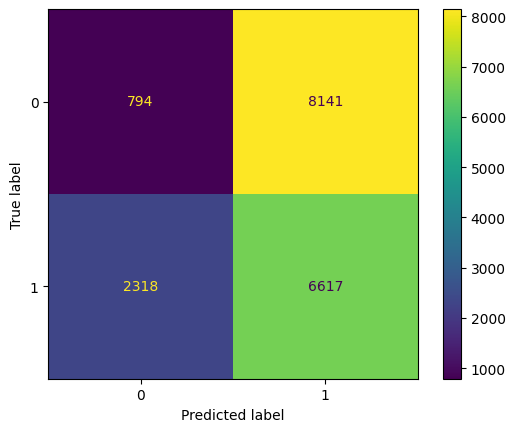


Training Dataset: WaveFake  Test Basis: FoR
Accuracy: 0.414717403469502
F1-score: 0.5585616004727134
Precision: 0.4483669873966662
Recall: 0.740570789031897


In [164]:
plotConfusionMatrix(testFoR['Pred_category'], testFoR['category'])
results("WaveFake", "FoR",testFoR["Pred_category"], testFoR["category"])

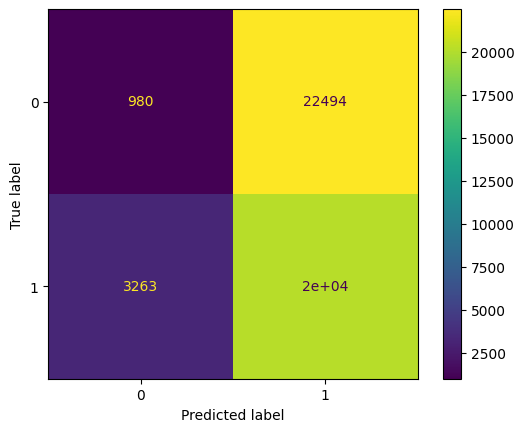


Training Dataset: WaveFake  Test Basis: ASV
Accuracy: 0.4513717304251512
F1-score: 0.6107979872769307
Precision: 0.47327010888654725
Recall: 0.860995143563091


In [165]:
plotConfusionMatrix(testASV['Pred_category'], testASV['category'])
results("WaveFake", "ASV",testASV["Pred_category"], testASV["category"])

# ASVspoof

In [167]:
os.chdir(Path + ASVPath)
modelASV = load_model("model-Mel.h5")
modelASV.load_weights("weights-best.hdf5")
modelASV.compile(
    loss='categorical_crossentropy',
    optimizer= opt,
    metrics=['categorical_accuracy']
)

In [168]:
testFoR = FoRData
FoRDatagen = datagenCreate(testFoR,
                        (Path + FoRPath),
                        IMAGE_SIZE,
                        batch_size)
predict = prediction(FoRDatagen,
                     len(testFoR["category"]),
                     batch_size,
                     modelASV)

testFoR['Pred_category'] = np.argmax(predict, axis=1)
testFoR['Pred_category'] = testFoR['Pred_category'].replace({1: 'Real', 0: 'Fake'})

Found 17870 validated image filenames belonging to 2 classes.
559/559 [==============================] - 472s 844ms/step


In [169]:
testFoR.to_csv('ASVtestFoR.csv', index=False)

In [170]:
testWave = WaveData
WaveDatagen = datagenCreate(testWave,
                        (Path + WavePath),
                        IMAGE_SIZE,
                        batch_size)
predict = prediction(WaveDatagen,
                     len(testWave["category"]),
                     batch_size,
                     modelASV)

testWave['Pred_category'] = np.argmax(predict, axis=1)
testWave['Pred_category'] = testWave['Pred_category'].replace({1: 'Real', 0: 'Fake'})

Found 86818 validated image filenames belonging to 2 classes.
2714/2714 [==============================] - 2063s 760ms/step


In [172]:
testWave.to_csv('ASVtestWave.csv', index=False)

<Figure size 640x480 with 0 Axes>

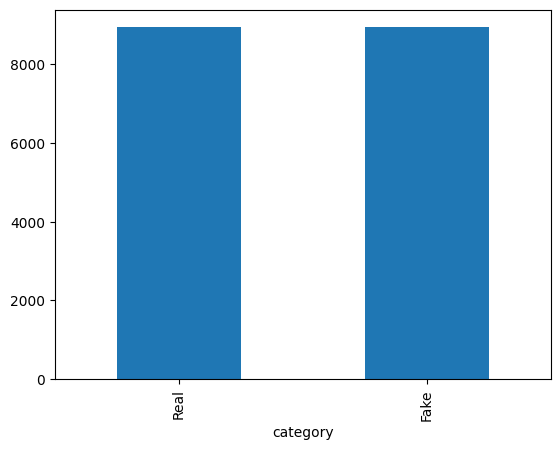

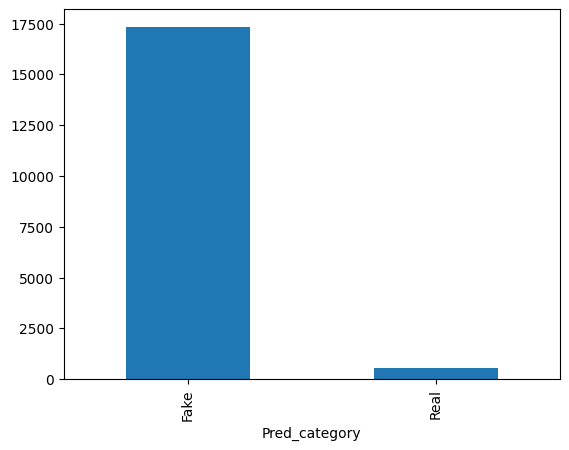

In [173]:
plt.figure()
plt.subplots(1, 1)
testFoR['category'].value_counts().plot.bar()
plt.subplots(1, 1)
testFoR['Pred_category'].value_counts().plot.bar()
plt.show()

<Figure size 640x480 with 0 Axes>

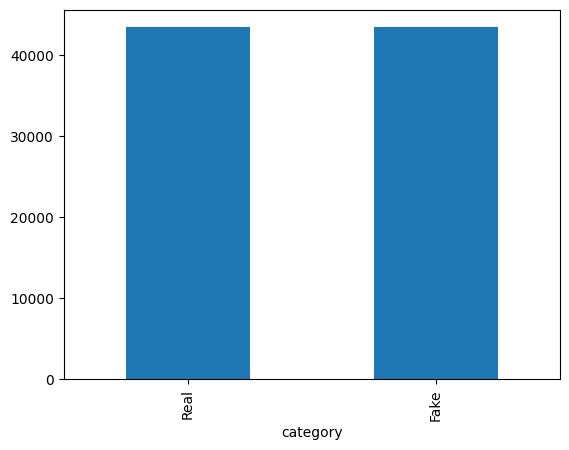

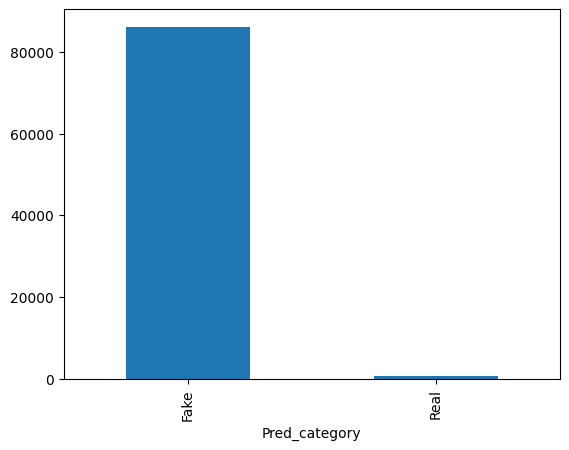

In [174]:
plt.figure()
plt.subplots(1, 1)
testWave['category'].value_counts().plot.bar()
plt.subplots(1, 1)
testWave['Pred_category'].value_counts().plot.bar()
plt.show()

In [175]:
testFoR['category'].value_counts()

category
Real    8935
Fake    8935
Name: count, dtype: int64

In [176]:
testFoR['Pred_category'].value_counts()

Pred_category
Fake    17332
Real      538
Name: count, dtype: int64

In [177]:
testWave['category'].value_counts()

category
Real    43409
Fake    43409
Name: count, dtype: int64

In [178]:
testWave['Pred_category'].value_counts()

Pred_category
Fake    86046
Real      772
Name: count, dtype: int64

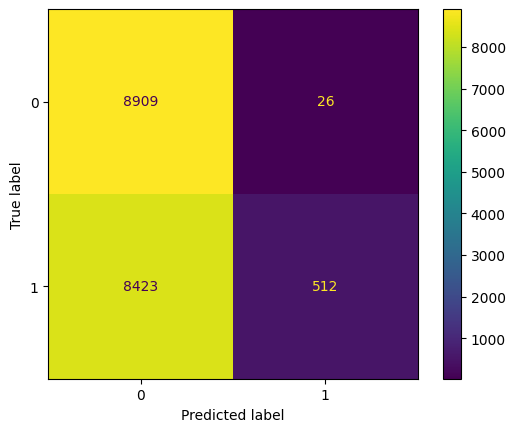


Training Dataset: ASVspoof  Test Basis: FoR
Accuracy: 0.5271964185786234
F1-score: 0.10809669587247968
Precision: 0.9516728624535316
Recall: 0.05730274202574147


In [179]:
plotConfusionMatrix(testFoR['Pred_category'], testFoR['category'])
results("ASVspoof", "FoR",testFoR["Pred_category"], testFoR["category"])

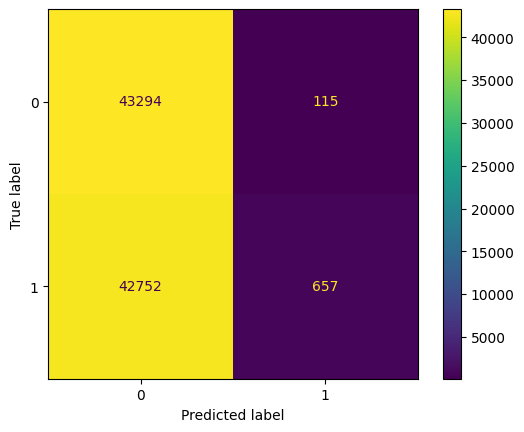


Training Dataset: ASVspoof  Test Basis: WaveFake
Accuracy: 0.5062429450114032
F1-score: 0.02974129150539825
Precision: 0.8510362694300518
Recall: 0.015135110230597342


In [180]:
plotConfusionMatrix(testWave['Pred_category'], testWave['category'])
results("ASVspoof", "WaveFake",testWave["Pred_category"], testWave["category"])

# Teste modelo base

## FoR-FoR

In [181]:
testFoR = FoRData
predict = prediction(FoRDatagen,
                     len(testFoR["category"]),
                     batch_size,
                     modelFoR)

testFoR['Pred_category'] = np.argmax(predict, axis=1)
testFoR['Pred_category'] = testFoR['Pred_category'].replace({1: 'Real', 0: 'Fake'})

559/559 [==============================] - 453s 810ms/step


<Figure size 640x480 with 0 Axes>

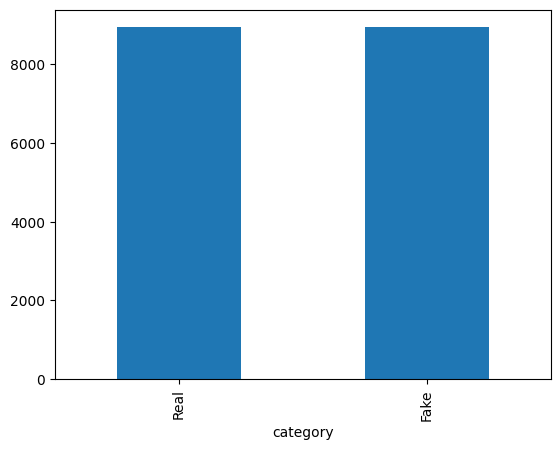

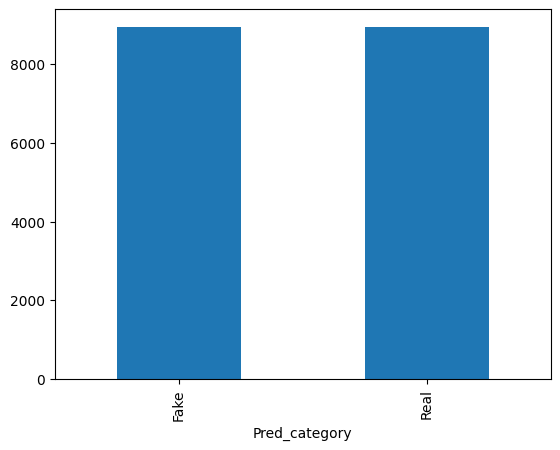

In [182]:
plt.figure()
plt.subplots(1, 1)
testFoR['category'].value_counts().plot.bar()
plt.subplots(1, 1)
testFoR['Pred_category'].value_counts().plot.bar()
plt.show()

In [183]:
testFoR['category'].value_counts()

category
Real    8935
Fake    8935
Name: count, dtype: int64

In [184]:
testFoR['Pred_category'].value_counts()

Pred_category
Fake    8936
Real    8934
Name: count, dtype: int64

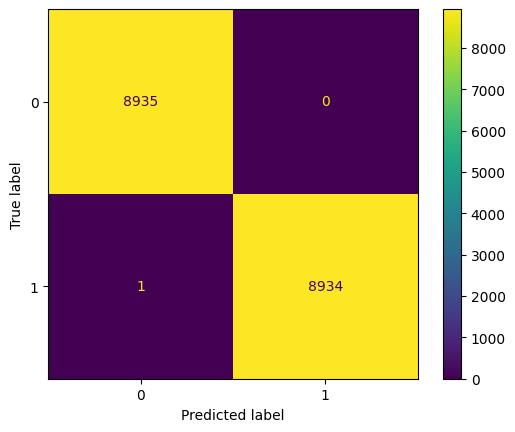


Training Dataset: FoR  Test Basis: FoR
Accuracy: 0.9999440402909905
F1-score: 0.9999440371593262
Precision: 1.0
Recall: 0.999888080581981


In [185]:
plotConfusionMatrix(testFoR['Pred_category'], testFoR['category'])
results("FoR", "FoR",testFoR["Pred_category"], testFoR["category"])

## WaveFake - WaveFake

In [186]:
testWave = WaveData
predict = prediction(WaveDatagen,
                     len(testWave["category"]),
                     batch_size,
                     modelWave)

testWave['Pred_category'] = np.argmax(predict, axis=1)
testWave['Pred_category'] = testWave['Pred_category'].replace({1: 'Real', 0: 'Fake'})

2714/2714 [==============================] - 2051s 756ms/step


<Figure size 640x480 with 0 Axes>

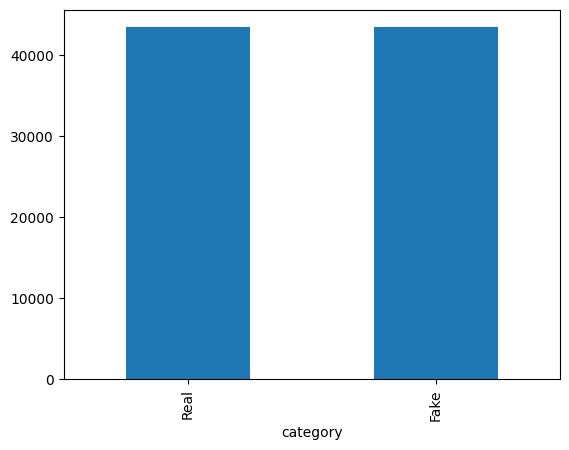

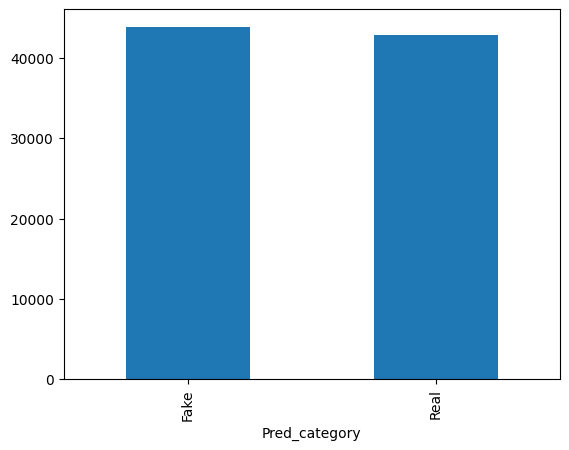

In [187]:
plt.figure()
plt.subplots(1, 1)
testWave['category'].value_counts().plot.bar()
plt.subplots(1, 1)
testWave['Pred_category'].value_counts().plot.bar()
plt.show()

In [188]:
testWave['category'].value_counts()

category
Real    43409
Fake    43409
Name: count, dtype: int64

In [189]:
testWave['Pred_category'].value_counts()

Pred_category
Fake    43879
Real    42939
Name: count, dtype: int64

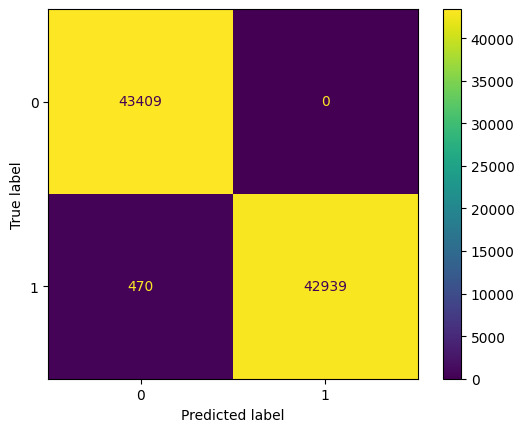


Training Dataset: WaveFake  Test Basis: WaveFake
Accuracy: 0.9945863760971227
F1-score: 0.994556909250938
Precision: 1.0
Recall: 0.9891727521942454


In [190]:
plotConfusionMatrix(testWave['Pred_category'], testWave['category'])
results("WaveFake", "WaveFake",testWave["Pred_category"], testWave["category"])

## ASVspoof - ASVspoof

In [191]:
testASV = ASVData
predict = prediction(ASVDatagen,
                     len(testASV["category"]),
                     batch_size,
                     modelASV)

testASV['Pred_category'] = np.argmax(predict, axis=1)
testASV['Pred_category'] = testASV['Pred_category'].replace({1: 'Real', 0: 'Fake'})

1468/1468 [==============================] - 943s 642ms/step


<Figure size 640x480 with 0 Axes>

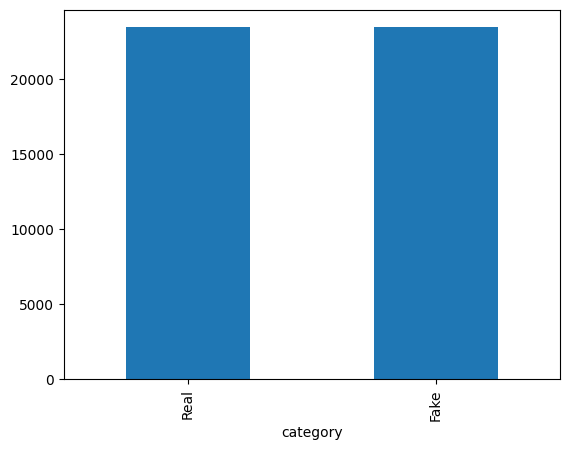

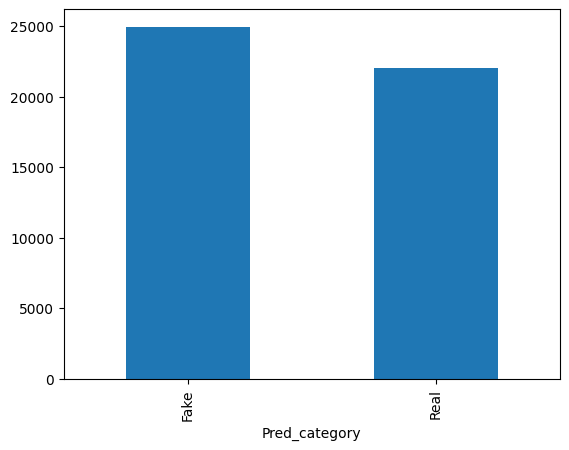

In [192]:
plt.figure()
plt.subplots(1, 1)
testASV['category'].value_counts().plot.bar()
plt.subplots(1, 1)
testASV['Pred_category'].value_counts().plot.bar()
plt.show()

In [194]:
testASV['category'].value_counts()

category
Real    23474
Fake    23474
Name: count, dtype: int64

In [193]:
testASV['Pred_category'].value_counts()

Pred_category
Fake    24917
Real    22031
Name: count, dtype: int64

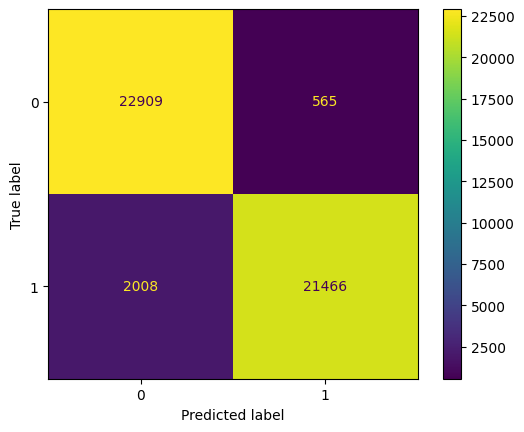


Training Dataset: ASVspoof  Test Basis: ASVspoof
Accuracy: 0.9451946834795945
F1-score: 0.9434567629930777
Precision: 0.9743543189142572
Recall: 0.9144585498849791


In [195]:
plotConfusionMatrix(testASV['Pred_category'], testASV['category'])
results("ASVspoof", "ASVspoof",testASV["Pred_category"], testASV["category"])